
# Module 2 Summative Lab

## Introduction

For today's section, we're going to work on a single big lab to apply everything we've learned in Module 2!

## About This Lab

A quick note before getting started--this lab isn't like other labs you seen so far. This lab is meant to take ~8 hours to complete, so it's much longer and more challenging that the average labs you've seen so far. If you feel like this lab is challenging or that you might be struggling a bit, don't fret--that's by design! With everything we've learned about Web Scraping, APIs, and Databases, the best way to test our knowledge of it is to build something substantial! 

## The Project

In this lab, we're going to make use of everything we've learned about APIs, databases, and Object-Oriented Programming to **_Extract, Transform, and Load_** (or **_ETL_**, for short) some data from a SQL database into a MongoDB Database. 

You'll find a database containing information about soccer teams and the matches they've played in the file `database.sqlite`. For this project, our goal is to get the data we think is important from this SQL database, do some calculations and data transformation, and then store everything in a MongoDB database. 

Let's get into the specifics of this project.



### The Goal

Start by examining the data dictionary for the SQL database we'll be working with, which comes from this [kaggle page](https://www.kaggle.com/laudanum/footballdelphi).  Familiarize yourself with the tables it contains, and what each column means. We'll be using this database to get data on each soccer team, calculate some summary statistics, and then store each in a MongoDB database. 

Upon completion of this lab, each unique team in this dataset should have a record in the MongoDB instance containing the following information:

* The name of the team
* The total number of goals scored by the team during the 2011 season
* The total nmumber of wins the team earned during the 2011 season
* A histogram visualization of the team's wins and losses for the 2011 season (store the visualization directly)
* The team's win percentage on days where it was raining during games in the 2011 season. 

In [1]:
# import libraries
import sqlite3
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import requests 
import os
import pymongo
import base64

In [2]:
# checkout the database 
conn = sqlite3.connect('database.sqlite')
cur = conn.cursor()

In [3]:
# check for tables in my database
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

[('sqlite_sequence',), ('Matches',), ('Teams_in_Matches',), ('Teams',), ('Unique_Teams',)]



# write a function to take a look at all tables

In [3]:
def extracttable(table, query=None):
    if query:
        cur.execute(query)
    else:
        cur.execute(f'SELECT * FROM {table}')
    dfname = pd.DataFrame(cur.fetchall())
    dfname.columns = [x[0] for x in cur.description]
    return dfname

In [27]:
# checkout the matches
# need Date, HomeTeam, AwayTeam, FTHG, FTAG, FTR 
extracttable('Matches').head(2)

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1,D2,2009,2010-04-04,Oberhausen,Kaiserslautern,2,1,H
1,2,D2,2009,2009-11-01,Munich 1860,Kaiserslautern,0,1,A


In [21]:
# checkout match_teamID join relationship
extracttable('Teams_in_Matches').head(2)

,Match_ID,Unique_Team_ID
0,1,26
1,1,46


In [22]:
# Teams
extracttable('Teams').head(2)

,Season,TeamName,KaderHome,AvgAgeHome,ForeignPlayersHome,OverallMarketValueHome,AvgMarketValueHome,StadiumCapacity
0,2017,Bayern Munich,27,26,15,597950000,22150000,75000
1,2017,Dortmund,33,25,18,416730000,12630000,81359


In [28]:
# unqiue teams
extracttable('Unique_Teams').head(2)

,TeamName,Unique_Team_ID
0,Bayern Munich,1
1,Dortmund,2


In [9]:
# sqlite_sequence
extracttable('sqlite_sequence').head(2)  # 46774 matches and 128 unique teams, couldbe less 128

,name,seq
0,Matches,46774
1,Unique_Teams,128


## looks like only need matches table for this project

In [4]:
query1 = """
WITH home_team AS (SELECT HomeTeam, 
                SUM(FTHG) AS total_goal_home, 
                SUM(CASE FTR WHEN 'H' THEN 1 ELSE 0 END) AS num_win_home,
                SUM(CASE FTR WHEN 'A' THEN 1 ELSE 0 END) AS num_loss_home
                FROM Matches
                WHERE Season = 2011
                GROUP BY HomeTeam),
    away_team AS (SELECT AwayTeam, 
                    SUM(FTAG) AS total_goal_away, 
                    SUM(CASE FTR WHEN 'A' THEN 1 ELSE 0 END) AS num_win_away,
                    SUM(CASE FTR WHEN 'H' THEN 1 else 0 END) as num_loss_away
                    FROM Matches
                    WHERE Season = 2011
                    GROUP BY AwayTeam)
    SELECT HomeTeam AS TeamName,
        total_goal_home + total_goal_away AS total_goal, 
        num_loss_home + num_loss_away AS total_loss, 
        num_win_away + num_win_home AS total_win
    FROM home_team
    JOIN away_team
    ON home_team.HomeTeam = away_team.AwayTeam;"""

In [5]:
# 
query1_df = extracttable('Matches',query1)
query1_df.head()# TeamName and total_goals

,TeamName,total_goal,total_loss,total_win
0,Aachen,30,15,6
1,Arsenal,74,10,21
2,Aston Villa,37,14,7
3,Augsburg,36,12,8
4,Bayern Munich,77,7,23


## We obtained TeamName, total_goals, total_loss, and total_wins by Team in season 2011

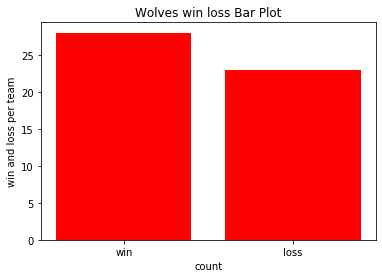

In [6]:
# create all images and save in the folder images as the name of the team.png 
for i, row in query1_df.iterrows():
    plt.bar(x = ['win','loss'], height = [row['total_win'],row['total_loss']], color = 'red')
    plt.title('{} win loss Bar Plot'.format(row['TeamName']))
    plt.xlabel ('count')
    plt.ylabel('win and loss per team')
    plt.savefig('images/{}.png'.format(row['TeamName']))

## add win and lose barcharts to the query1_df column image

In [23]:
Images = []  # save the png as base64 strings 
for i, row in query1_df.iterrows():
    Team_Name = row['TeamName']
    with open("images/{}.png".format(Team_Name),'rb') as imageFile:
        s = base64.b64encode(imageFile.read())
        Images.append(s)

In [26]:
# add the images to the column and remove the total_loss column
query1_df['Images'] = Images
query1_df.drop(columns = ['total_loss'],inplace=True )

In [27]:
query1_df.head()

,TeamName,total_goal,total_win,Images
0,Aachen,30,6,b'iVBORw0KGgoAAAANSUhEUgAAAbAAAAEgCAYAAADVKCZp...
1,Arsenal,74,21,b'iVBORw0KGgoAAAANSUhEUgAAAbAAAAEgCAYAAADVKCZp...
2,Aston Villa,37,7,b'iVBORw0KGgoAAAANSUhEUgAAAbAAAAEgCAYAAADVKCZp...
3,Augsburg,36,8,b'iVBORw0KGgoAAAANSUhEUgAAAbAAAAEgCAYAAADVKCZp...
4,Bayern Munich,77,23,b'iVBORw0KGgoAAAANSUhEUgAAAbAAAAEgCAYAAADVKCZp...


#### Getting the Weather Data

Note that for this last calculation, you'll need to figure out if it was raining or not during the game. The database itself does not contain this information, but it does contain the date on which the game was played. For this, you'll need to use the [DarkSky API](https://darksky.net/dev) to get the historical weather data for that day. Note that each game is played in a different location, and this information is not contained in our SQL database. However, the teams in this database are largely german, so go ahead and just use the weather in Berlin, Germany as a proxy for this information. If it was raining in Berlin on the day the game was played, count that as rain game--**_you do not need to try and figure out the actual weather at each game's location, because we don't have that information!_**

#### NOTE: The DarkSky API is limited to 1000 free API calls a day, so be sure to test your model on very small samples. Otherwise, you'll hit the rate limit!



In [28]:
query2 = """
                SELECT  Date,
                        HomeTeam AS Team, 
                        FTHG AS num_goals,
                        CASE FTR WHEN 'H' THEN 1 ELSE 0 END AS num_win
                FROM Matches
                WHERE Season = 2011
                UNION ALL 
                SELECT  Date,
                        AwayTeam AS Team,
                        FTAG AS num_goals,
                        CASE FTR WHEN 'A' THEN 1 ELSE 0 END AS num_win_away
                FROM Matches
                WHERE Season = 2011;
        """

In [29]:
query2_df = extracttable('Matches',query2)
query2_df.head()

,Date,Team,num_goals,num_win
0,2012-03-31,Nurnberg,0,0
1,2011-12-11,Stuttgart,1,0
2,2011-08-13,Wolfsburg,0,0
3,2011-11-27,Mainz,3,1
4,2012-02-18,Freiburg,0,0


In [30]:
# convert Date to timestamp 
query2_df['Date'] = pd.to_datetime(query2_df.Date)

In [31]:
# convert timestamp to unixtime as date object for api filter
query2_df['Unixtime'] = query2_df.Date.apply(lambda x: x.value//10**9) 

## Weather getter class to take in lat_lon and obtain a the match dataframe with only the rainingday rows

In [32]:
lat_lon = '52.5200,13.4050'  # lat_lon for Berlin Germany 
class RainGetter():
    '''
    Initialize a class with a base url without unixtime 
    '''
    def __init__(self,lat_lon):
        self.lat_lon = lat_lon
        key = os.environ.get('WEATHERKEY')
        base_url = 'https://api.darksky.net/forecast/'
        self.url = '/'.join(s.strip('/') for s in [base_url, key,lat_lon])
    
    def is_raining(self,unixtime):
        '''
        adds specific unix time and returns true or false for raining 
        '''
        url = f'{self.url},{unixtime}'
        resp = requests.get(url)
        if resp.json()['daily']['data'][0].get('precipType') == 'rain':
            return True
        return False
    def raining_by_day(self, time_list):
        '''
        creates a dictionary of unix time to raining day 
        '''
        raining_day ={}
        for time in time_list:
            raining_day[time] = self.is_raining(time)
        return raining_day
    def team_info_rain(self, df_frame, time_list):
        '''
        returns filtered dataframe with only raining days 
        '''
        ind = df_frame['Unixtime'].map(self.raining_by_day(time_list))
        return df_frame[ind]

In [33]:
# initialize the class 
Rain_matches = RainGetter(lat_lon)
# only need to look at unique unix time to reduce requests 
time_list = query2_df.Unixtime.unique().tolist()  # 165 unique times

In [51]:
# Don't run this again to prevent extra api calls due to 1000 limiations 

# rain_matches = Rain_matches.team_info_rain(query2_df, time_list)

In [35]:
# create toal_game list and total_win list per team table for percent calculation 
total_game = rain_matches.groupby('Team').size().tolist()
wins = rain_matches.groupby('Team')['num_win'].sum().tolist()
team_index = rain_matches.groupby('Team').size().index  # both have the same team index 

In [36]:
# map a percent win dictionary to add to the query_1 df 
percent_win = {}
for i in range(len(team_index)):
    percent_win[team_index[i]] = wins[i]/total_game[i]*100

In [38]:
# map into final merged df 
query1_df['percent_win_rain'] = query1_df['TeamName'].map(percent_win)

In [41]:
# convert them to dictionary to store in mongodb 
documents = query1_df.to_dict(orient='records')

## create mongoloader class to add records into collections 

In [44]:
class MongoLoader():
    '''
    initialize a mongodb with a db_name and table name 
    '''
    def __init__(self, db_name, collection_name):
        self.db_name = db_name
        self.collection_name = collection_name
        # create the connection to mongo
        myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/")
        # create a database with db_name 
        mydb = myclient[self.db_name]
        # create table with collection_name 
        self.mycollection = mydb[self.collection_name]
    
    def add_documents(self, docs):
        '''
        add documents to the collection 
        '''
        # if docs is not empty 
        if docs:
            if len(docs)==1:  # only one document 
                self.mycollection.insert_one(docs)
            else:
                self.mycollection.insert_many(docs)
    
    def update_document(self,Team_Name, key, value):
        '''
        update documents in the collection with a specific team_name
        '''
        if self.mycollection.count():  # make sure it is not empty 
            record_to_update = {'TeamName':Team_Name }
            update = {'$set':{key:value}}
            self.mycollection.update_one(record_to_update, update)
            
    def image_to_string(self, image_name):
        '''
        convert image to string 
        '''
        with open(image_name,'rb') as imageFile:
            s = base64.b64encode(imageFile.read())
        return s 
    
    def add_image(self, Team_Name, image_name):
        '''
        adds image to a team document 
        '''
        if self.mycollection.count():  # make sure it is not empty 
            record_to_update = {'TeamName':Team_Name}
            s = self.image_to_string(image_name)
            update = {'$set':{'image':s}}
            self.mycollection.update_one(record_to_update, update)

In [45]:
# add our documents to my_db withname german_soccer 
# create an instance
DB_Soccer = MongoLoader('mydb','German_Soccer')

In [46]:
DB_Soccer.collection_name

'German_Soccer'

In [47]:
# first add documents 
DB_Soccer.add_documents(documents)

In [53]:
# check to see we have 56 collections
DB_Soccer.mycollection.count_documents({})

56

In [54]:
# check for records 
query_1=DB_Soccer.mycollection.find({})

i = 0 
for x in query_1:
    if i < 3:
        print(x)
    i+= 1
        

{'_id': ObjectId('5d1823377add232b26d0538d'), 'TeamName': 'Aachen', 'total_goal': 30, 'total_win': 6, 'Images': b'iVBORw0KGgoAAAANSUhEUgAAAbAAAAEgCAYAAADVKCZpAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjAsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+17YcXAAAgAElEQVR4nO3deXiNd/7/8dchoZpEIhIim6BqJ5Wglixq0GK0SimqEq1MN9pqzXS+natlrnZqKEq1NenYS21tVWlNF1uQtg61RCptEUssTWhIRGS7f3/4zbkmRWlybie383xc17ku514+7/fNkdf1ue8797EZhmEIAACLqebqBgAAqAgCDABgSQQYAMCSCDAAgCURYAAASyLAAACWRIABACyJAAMAWBIBBgCwJAIMAGBJBBgAwJIIMACAJRFgAABLIsAAAJZEgAEALIkAAwBYEgEGALAkAgwAYEkEGCwhISFBf/vb31zdhkNKSoqaNWtWoX3nz5+vbt26ObmjqsmdjhU3HgEGU8THx6tOnTq6ePGiq1sxRUxMjDIyMlzdxjVlZmbKZrPJ29tb3t7eql+/vp544gkVFxc7rcaECRPk6ekpb29v+fn5qUuXLkpNTf3d48THx+vf//630/rCzY8Ag9NlZmYqJSVFNptNq1evdnU7kJSbm6v8/Hzt3btXqampeuuttyo0TklJyRWXDxkyRPn5+crOzla3bt10//33yzCMyrQMXBMBBqdbuHCh7rzzTiUkJGjBggXl1q1du1Z33HGHateurbCwME2YMKHc+i1btqhLly7y8/NTWFiY5s+f71j3yy+/qG/fvvLx8VGnTp104MABx7r9+/erZ8+e8vf3V7NmzbR8+XLHuo